In [1]:
d <- read.csv("e1-comb-data.csv")
d$coverage_inc <- d$edges_covered - d$initial_coverage
# d$cif <- factor(d$coverage_inc, ordered=TRUE)
d <- d[c("benchmark", "fuzzer", "corpus", "corpus_size",
                "initial_coverage", "ineq_reached", "ineq_unexplored",
                "indir_reached", "shared_reached", "mean_exec_ns",
                "mean_size_bytes", "coverage_inc", "eq_reached", "eq_unexplored", "per_target_trial")]


head(d)

,benchmark,fuzzer,corpus,corpus_size,initial_coverage,ineq_reached,ineq_unexplored,indir_reached,shared_reached,mean_exec_ns,mean_size_bytes,coverage_inc,eq_reached,eq_unexplored,per_target_trial
,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,lcms-2017-03-21,afl,e1v0-afl,5,1098,229,196,18,0,3220828,648.0000,454,967,806,0
2,sqlite3_ossfuzz,afl,e1v0-afl,279,13209,3660,2769,56,0,3582894,1533.8387,2909,12562,9641,0
3,zlib_zlib_uncompress_fuzzer,afl,e1v0-afl,26,374,185,142,4,0,2563850,447.6538,78,419,328,0
4,lcms-2017-03-21,afl,e1v0-afl,1,394,146,138,16,0,3215764,132.0000,191,428,400,1
5,sqlite3_ossfuzz,afl,e1v0-afl,29,9387,2613,2120,45,0,3122302,1686.9310,4274,8995,7367,1
6,zlib_zlib_uncompress_fuzzer,afl,e1v0-afl,1,194,139,128,4,0,2412663,40.0000,260,335,311,1


Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”


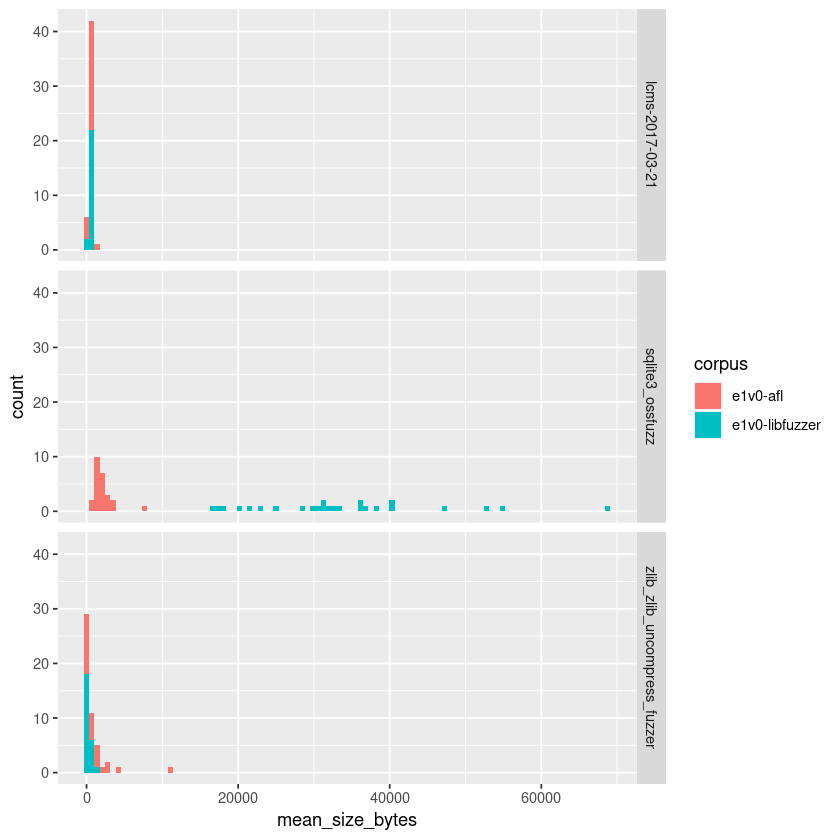

In [3]:
library("ggplot2")
require(dplyr)

ggp <- ggplot(d %>% filter(fuzzer == "afl"), aes(mean_size_bytes, fill = corpus)) + geom_histogram(bins=100)
ggp + facet_grid(benchmark ~ .) 


NULL

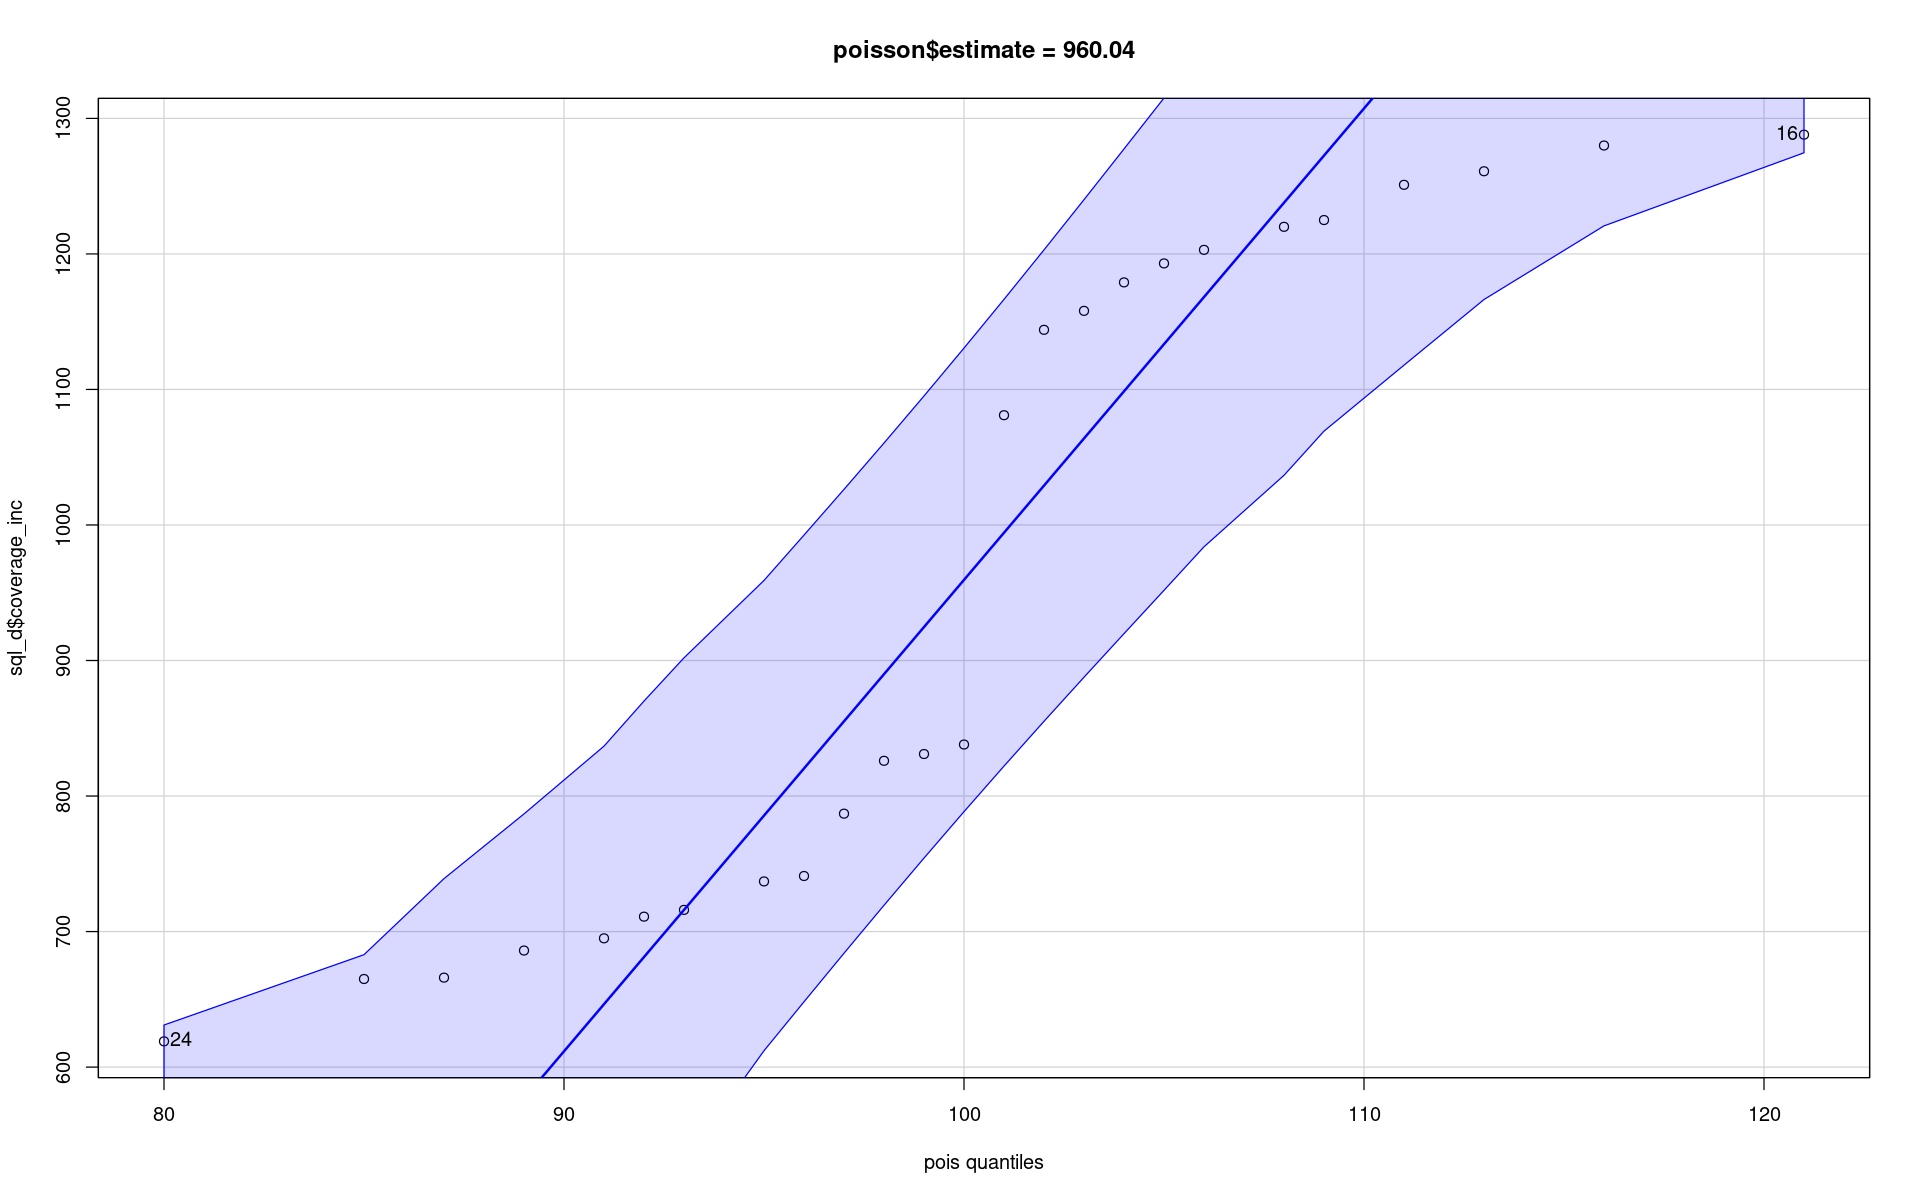

[1] 24 16


	Shapiro-Wilk normality test

data:  sql_d$coverage_inc
W = 0.83595, p-value = 0.0009643


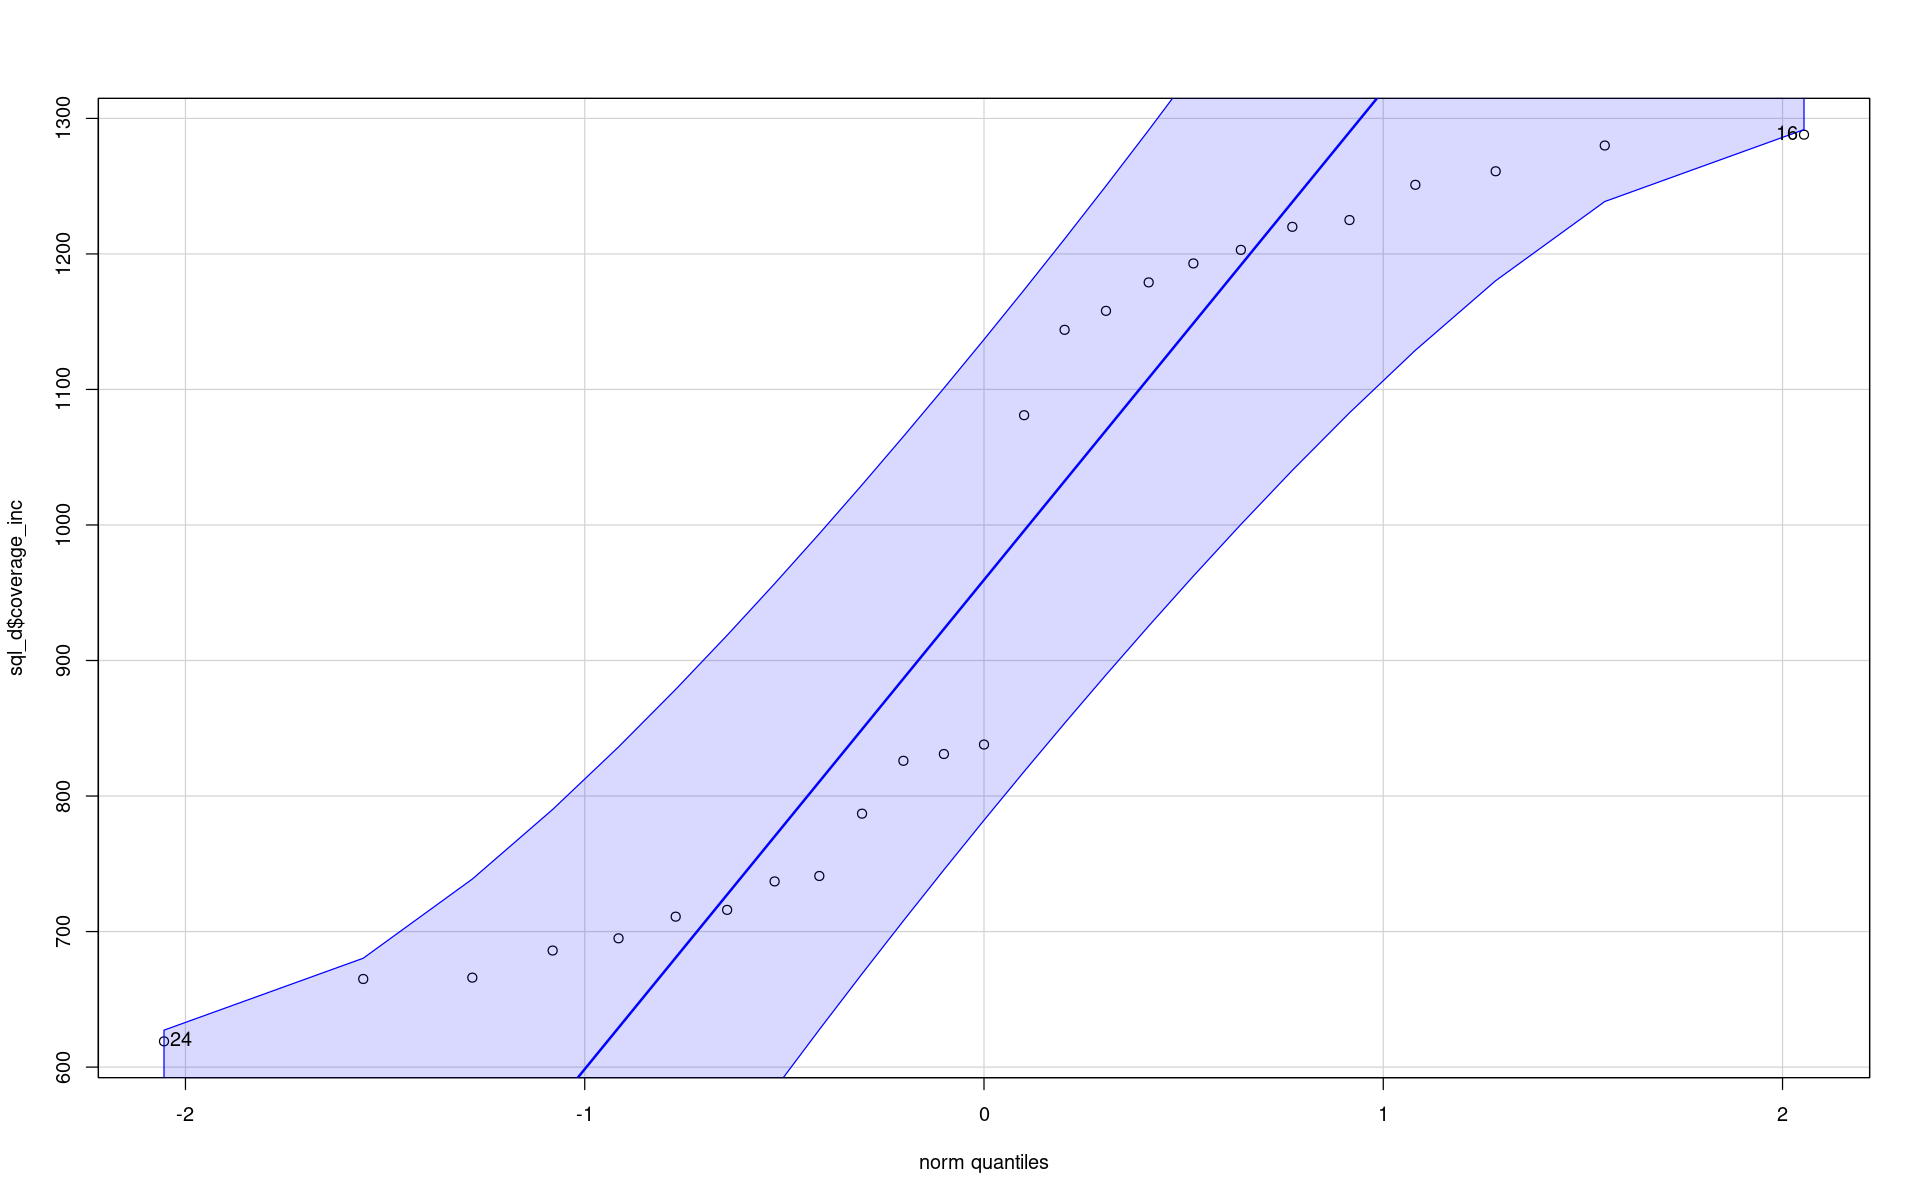

In [86]:
require(car)
require(MASS)
require(dplyr)
# This is so that distributions that must be non-zero can make sense of my
# data

sql_d <- d %>% filter(benchmark == "lcms-2017-03-21") %>% filter(fuzzer == "libfuzzer") %>% filter(corpus == "e1v0-afl")

poisson <- fitdistr(sql_d$coverage_inc, "Poisson")
qqp(sql_d$coverage_inc, "pois", poisson$estimate, lambda = 100) + facet_grid(fuzzer ~ .)

qqp(sql_d$coverage_inc, "norm")
shapiro.test(sql_d$coverage_inc)


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



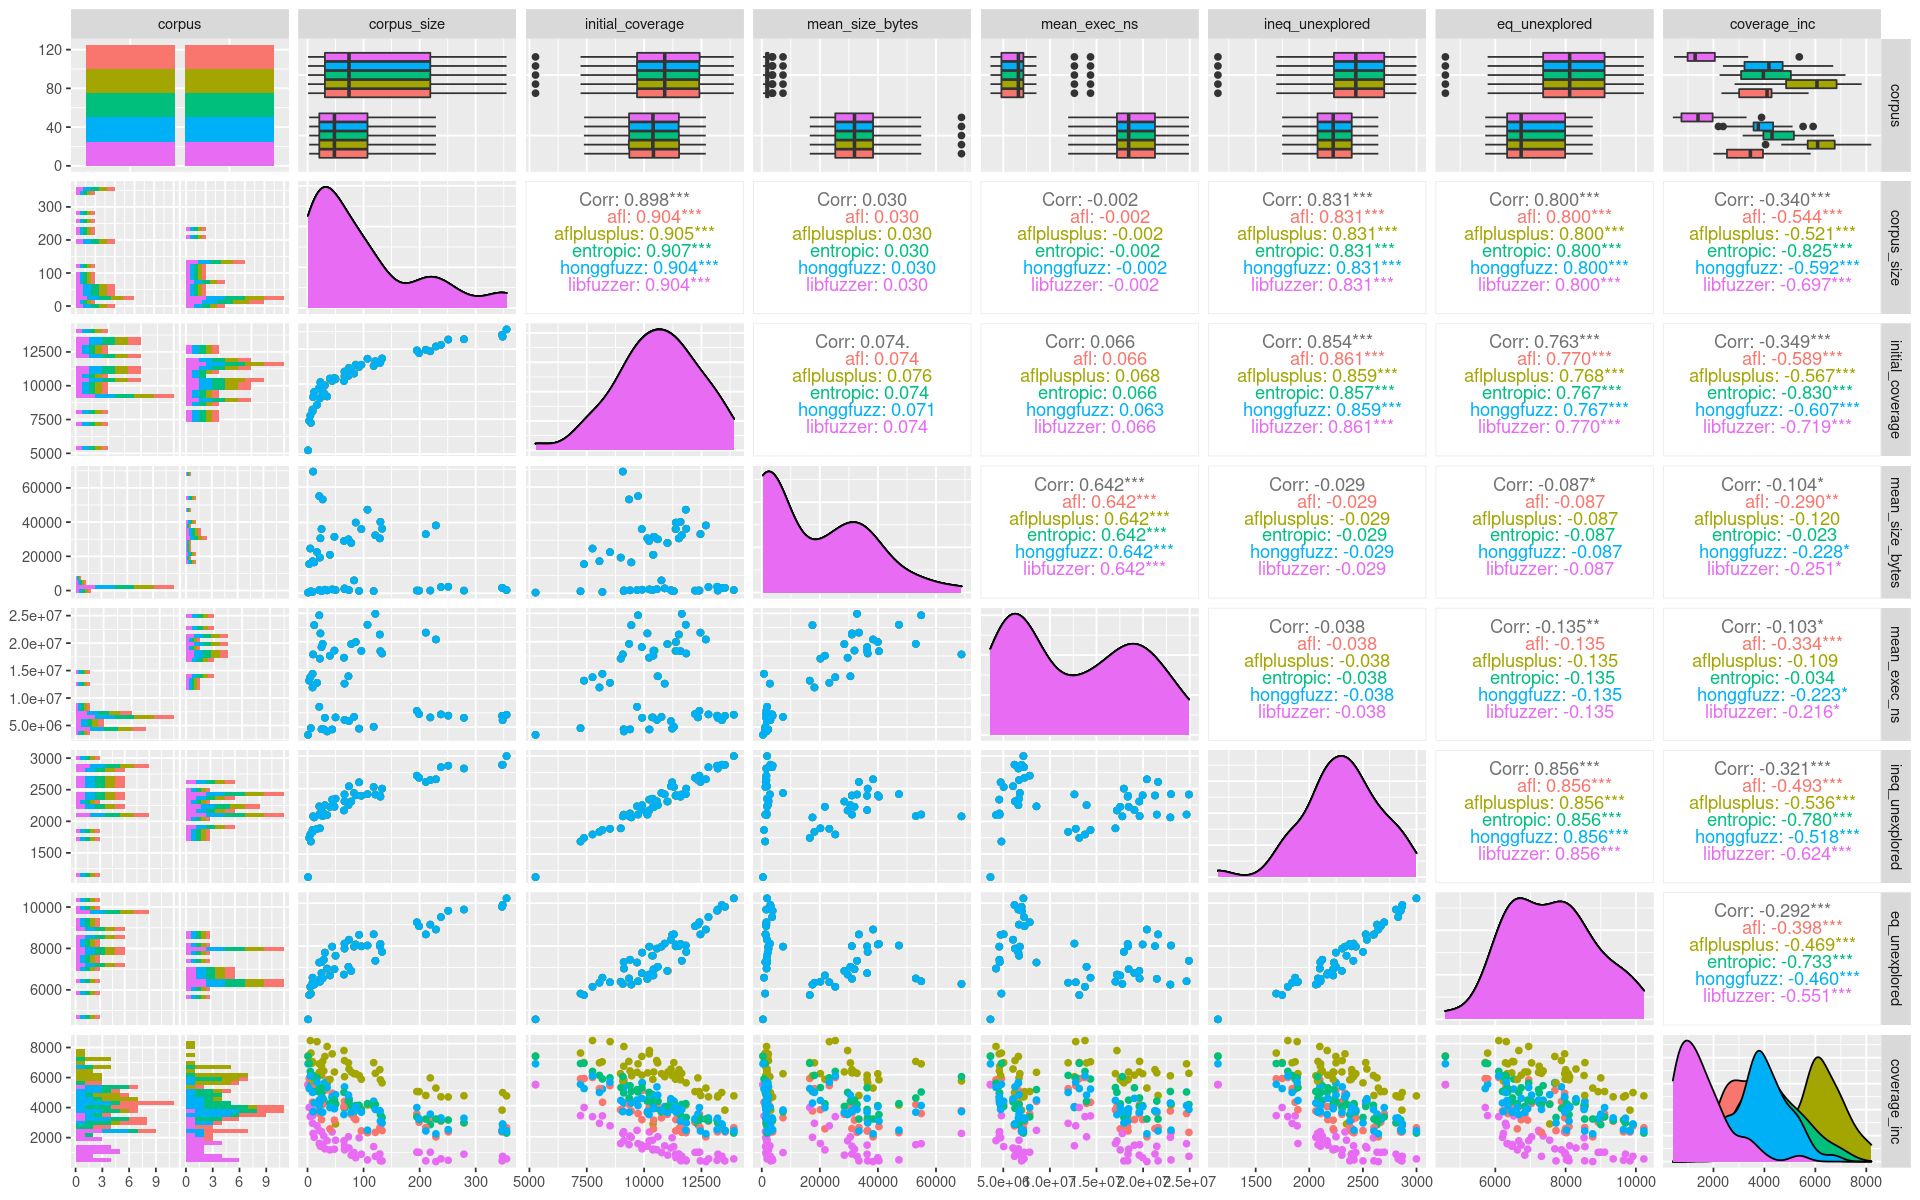

In [21]:
# install.packages("GGally")

library(GGally)
library(repr)

options(repr.plot.width=16, repr.plot.height=10)
vars = c("corpus", "corpus_size", "initial_coverage", "mean_size_bytes", "mean_exec_ns", "ineq_unexplored", "eq_unexplored", "coverage_inc")

# display a pairplot of all four columns of data
GGally::ggpairs(d %>% filter(benchmark == "sqlite3_ossfuzz"), columns = vars, ggplot2::aes(color = fuzzer), upper = list(continuous = wrap("cor", method = "kendall")))

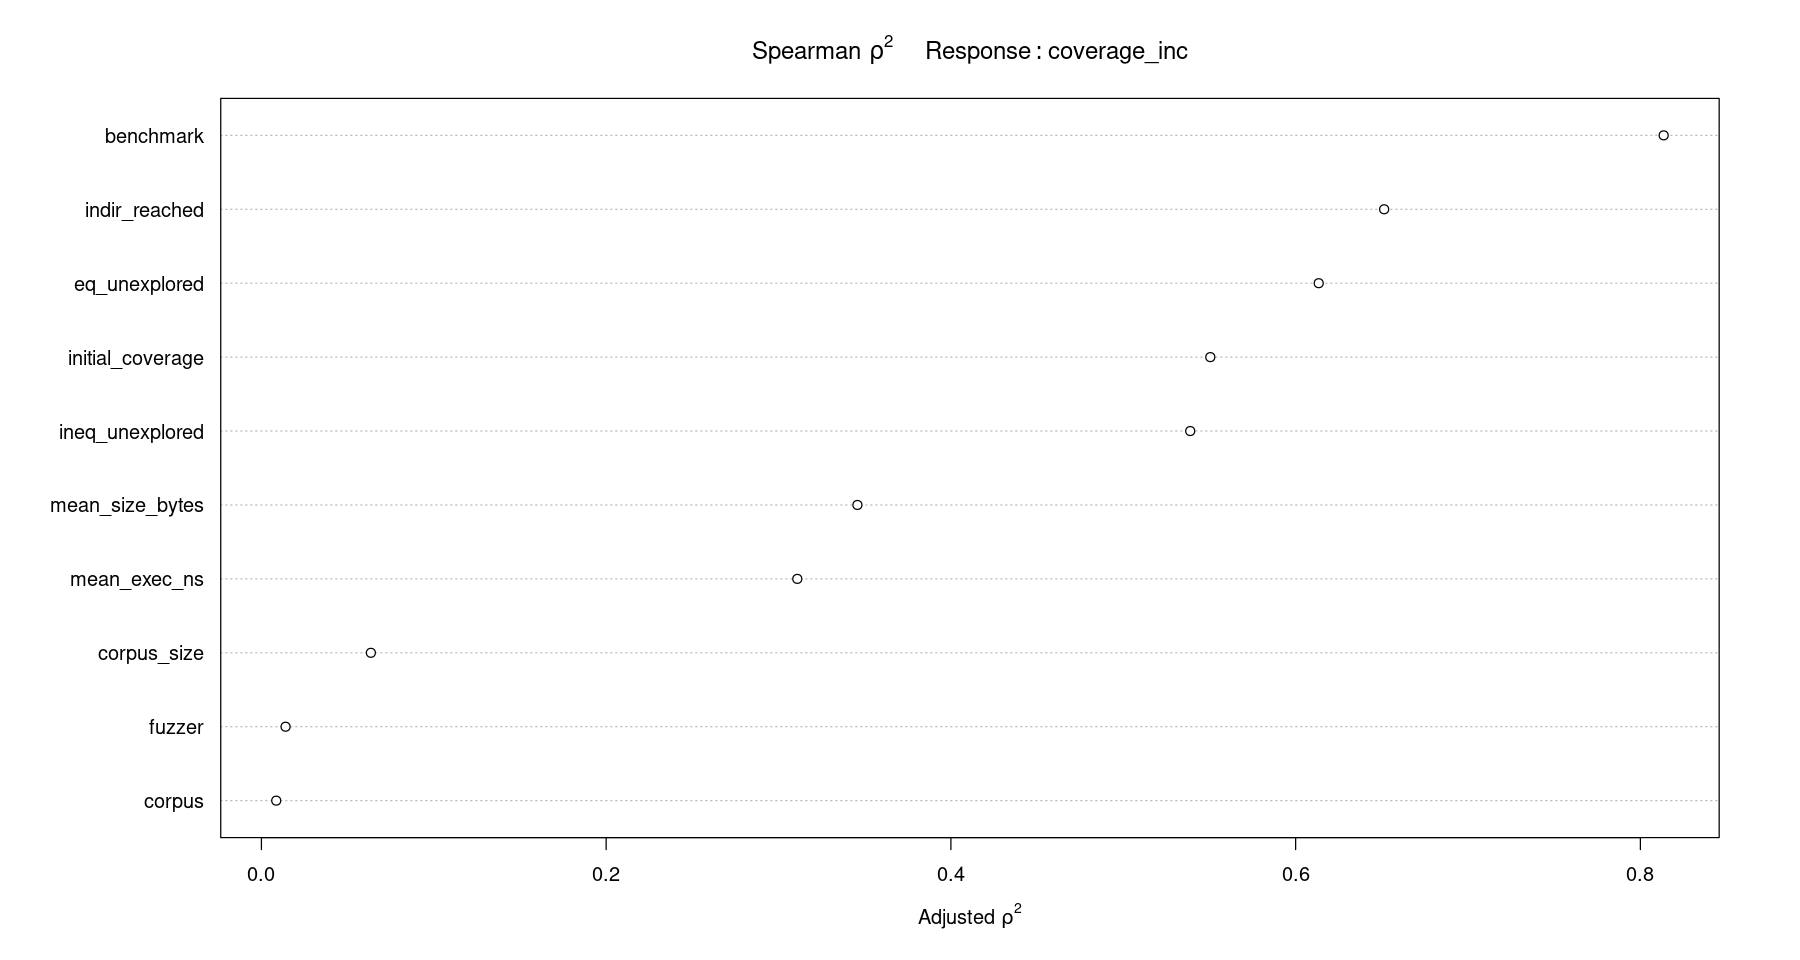

In [70]:
library("rms")

rms_d <- d

s <- spearman2(coverage_inc ~ corpus + corpus_size + initial_coverage +
               mean_size_bytes + mean_exec_ns + ineq_unexplored +
               eq_unexplored + indir_reached + fuzzer + benchmark, data=rms_d)
plot(s)

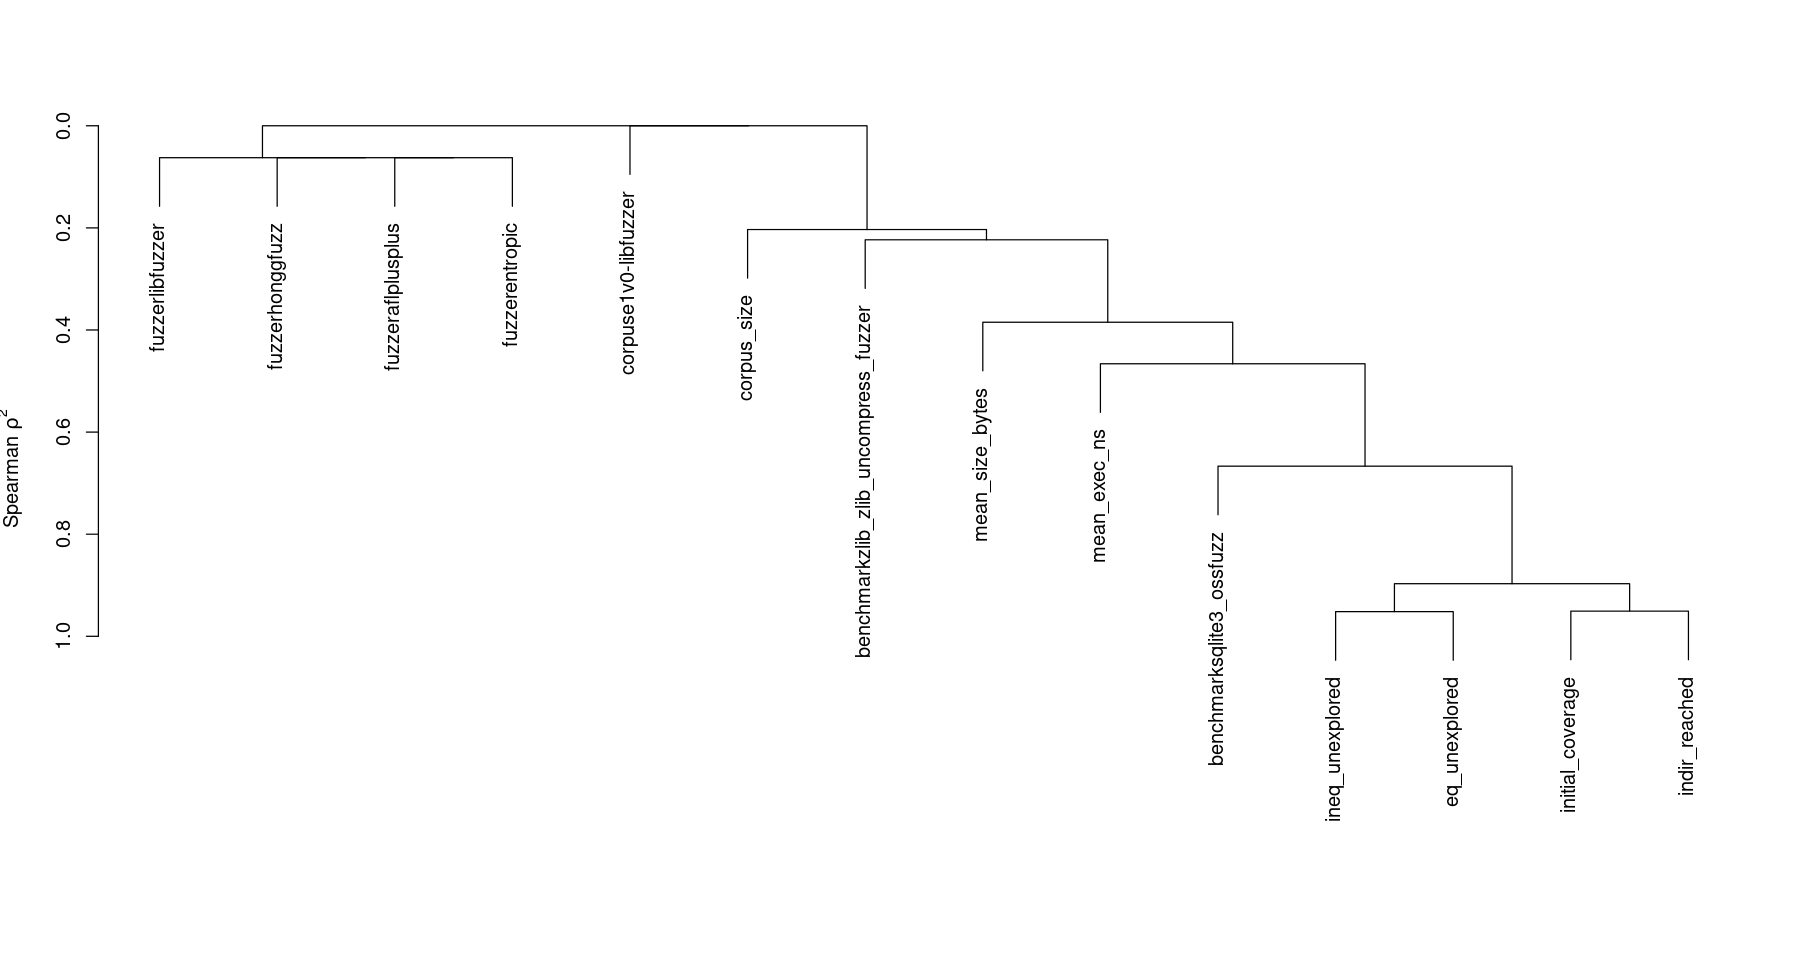

In [71]:
v <- varclus(~ corpus + corpus_size + initial_coverage +
               mean_size_bytes + mean_exec_ns + ineq_unexplored +
               eq_unexplored + fuzzer + indir_reached + benchmark, data=rms_d)
plot(v)


In [118]:
model <- orm(formula = coverage_inc ~ corpus + fuzzer + initial_coverage + corpus*fuzzer,
             data = rms_d %>% filter(benchmark == "sqlite3_ossfuzz") )
model
AIC(model)

model <- orm(formula = coverage_inc ~ corpus + fuzzer + initial_coverage + corpus*fuzzer,
             data = rms_d %>% filter(benchmark == "lcms-2017-03-21") )
model
AIC(model)



Logistic (Proportional Odds) Ordinal Regression Model
 
 orm(formula = coverage_inc ~ corpus + fuzzer + initial_coverage + 
     corpus * fuzzer, data = rms_d %>% filter(benchmark == "sqlite3_ossfuzz"))
 
                        Model Likelihood               Discrimination    Rank Discrim.    
                              Ratio Test                      Indexes          Indexes    
 Obs           250    LR chi2     629.60    R2                  0.919    rho     0.955    
 Distinct Y    242    d.f.            10    R2(10,250)          0.916                     
 Median Y     3934    Pr(> chi2) <0.0001    R2(10,250)          0.916                     
 max |deriv| 3e-05    Score chi2  602.98    |Pr(Y>=median)-0.5| 0.409                     
                      Pr(> chi2) <0.0001                                                  
 
                                            Coef    S.E.   Wald Z Pr(>|Z|)
 corpus=e1v0-libfuzzer                      -2.8982 0.5351  -5.42 <0.0001 
 fuzze

[1] 2610.955

Logistic (Proportional Odds) Ordinal Regression Model
 
 orm(formula = coverage_inc ~ corpus + fuzzer + initial_coverage + 
     corpus * fuzzer, data = rms_d %>% filter(benchmark == "lcms-2017-03-21"))
 
                         Model Likelihood               Discrimination    Rank Discrim.    
                               Ratio Test                      Indexes          Indexes    
 Obs            250    LR chi2     484.96    R2                  0.856    rho     0.901    
 Distinct Y     222    d.f.            10    R2(10,250)          0.850                     
 Median Y       695    Pr(> chi2) <0.0001    R2(10,250)          0.850                     
 max |deriv| 0.0007    Score chi2  442.17    |Pr(Y>=median)-0.5| 0.388                     
                       Pr(> chi2) <0.0001                                                  
 
                                            Coef    S.E.   Wald Z Pr(>|Z|)
 corpus=e1v0-libfuzzer                       7.0628 0.6892  10.25 <0.0001 

[1] 2656.995

In [120]:
require(dplyr)
# get coefficients (it's in matrix form)

model$stats
coefficients <- data.frame(model$coefficients)

# calculate p-values
p_value <- (1 - pnorm(abs(as.matrix(coefficients["t.value"])), 0, 1))*2
colnames(p_value)[1] <- "p_value"

# bind back to coefficients
coefficients <- cbind(coefficients, p_value)

# calculate odds ratios
odds_ratio <- exp(coefficients[ ,"Estimate"])

# combine with coefficient and p_value
(coefficients <- cbind(
  coefficients[ ,c("Estimate", "p_value")],
  odds_ratio
))

Obs   Distinct Y     Median Y    Max Deriv   Model L.R.         d.f. 
2.500000e+02 2.220000e+02 6.950000e+02 6.551046e-04 4.849637e+02 1.000000e+01 
           P        Score      Score P          rho           R2      R2(250) 
0.000000e+00 4.421750e+02 0.000000e+00 9.008196e-01 8.562941e-01 8.562752e-01 
  R2(10,250)      R2(250)   R2(10,250)            g           gr          pdm 
8.504097e-01 8.562833e-01 8.504179e-01 5.819323e+00 3.367442e+02 3.881056e-01

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'as.matrix': undefined columns selected


In [121]:
library(lme4)

model <- glmer(formula = coverage_inc ~ benchmark + corpus + fuzzer + (1 | mean_size_bytes) +
              (1 | initial_coverage) + corpus*fuzzer*benchmark, data = rms_d)
model



Warning message in glmer(formula = coverage_inc ~ benchmark + corpus + fuzzer + :
“calling glmer() with family=gaussian (identity link) as a shortcut to lmer() is deprecated; please call lmer() directly”


Linear mixed model fit by REML ['lmerMod']
Formula: coverage_inc ~ benchmark + corpus + fuzzer + (1 | mean_size_bytes) +  
    (1 | initial_coverage) + corpus * fuzzer * benchmark
   Data: rms_d
REML criterion at convergence: 10532.58
Random effects:
 Groups           Name        Std.Dev.
 initial_coverage (Intercept) 437.5   
 mean_size_bytes  (Intercept) 563.9   
 Residual                     180.5   
Number of obs: 749, groups:  initial_coverage, 303; mean_size_bytes, 148
Fixed Effects:
                                                                (Intercept)  
                                                                     470.68  
                                                   benchmarksqlite3_ossfuzz  
                                                                    3187.92  
                                       benchmarkzlib_zlib_uncompress_fuzzer  
                                                                    -315.68  
                                     

In [59]:
library(lme4)

rms_d <- d %>% filter(benchmark == "lcms-2017-03-21")
model <- glmer(formula = coverage_inc ~ corpus + fuzzer + (1 | mean_size_bytes) +
              (1 | initial_coverage) + corpus*fuzzer + fuzzer*initial_coverage, data = rms_d)
model


Warning message in glmer(formula = coverage_inc ~ corpus + fuzzer + (1 | mean_size_bytes) + :
“calling glmer() with family=gaussian (identity link) as a shortcut to lmer() is deprecated; please call lmer() directly”
boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML ['lmerMod']
Formula: coverage_inc ~ corpus + fuzzer + (1 | mean_size_bytes) + (1 |  
    initial_coverage) + corpus * fuzzer + fuzzer * initial_coverage
   Data: rms_d
REML criterion at convergence: 3081.74
Random effects:
 Groups           Name        Std.Dev.
 mean_size_bytes  (Intercept)  43.53  
 initial_coverage (Intercept)   0.00  
 Residual                     133.03  
Number of obs: 249, groups:  mean_size_bytes, 48; initial_coverage, 48
Fixed Effects:
                           (Intercept)                    corpuse1v0-libfuzzer  
                             1020.3088                                422.2529  
                     fuzzeraflplusplus                          fuzzerentropic  
                              619.7909                                817.6940  
                       fuzzerhonggfuzz                         fuzzerlibfuzzer  
                              642.4657                                713.1209  
                  

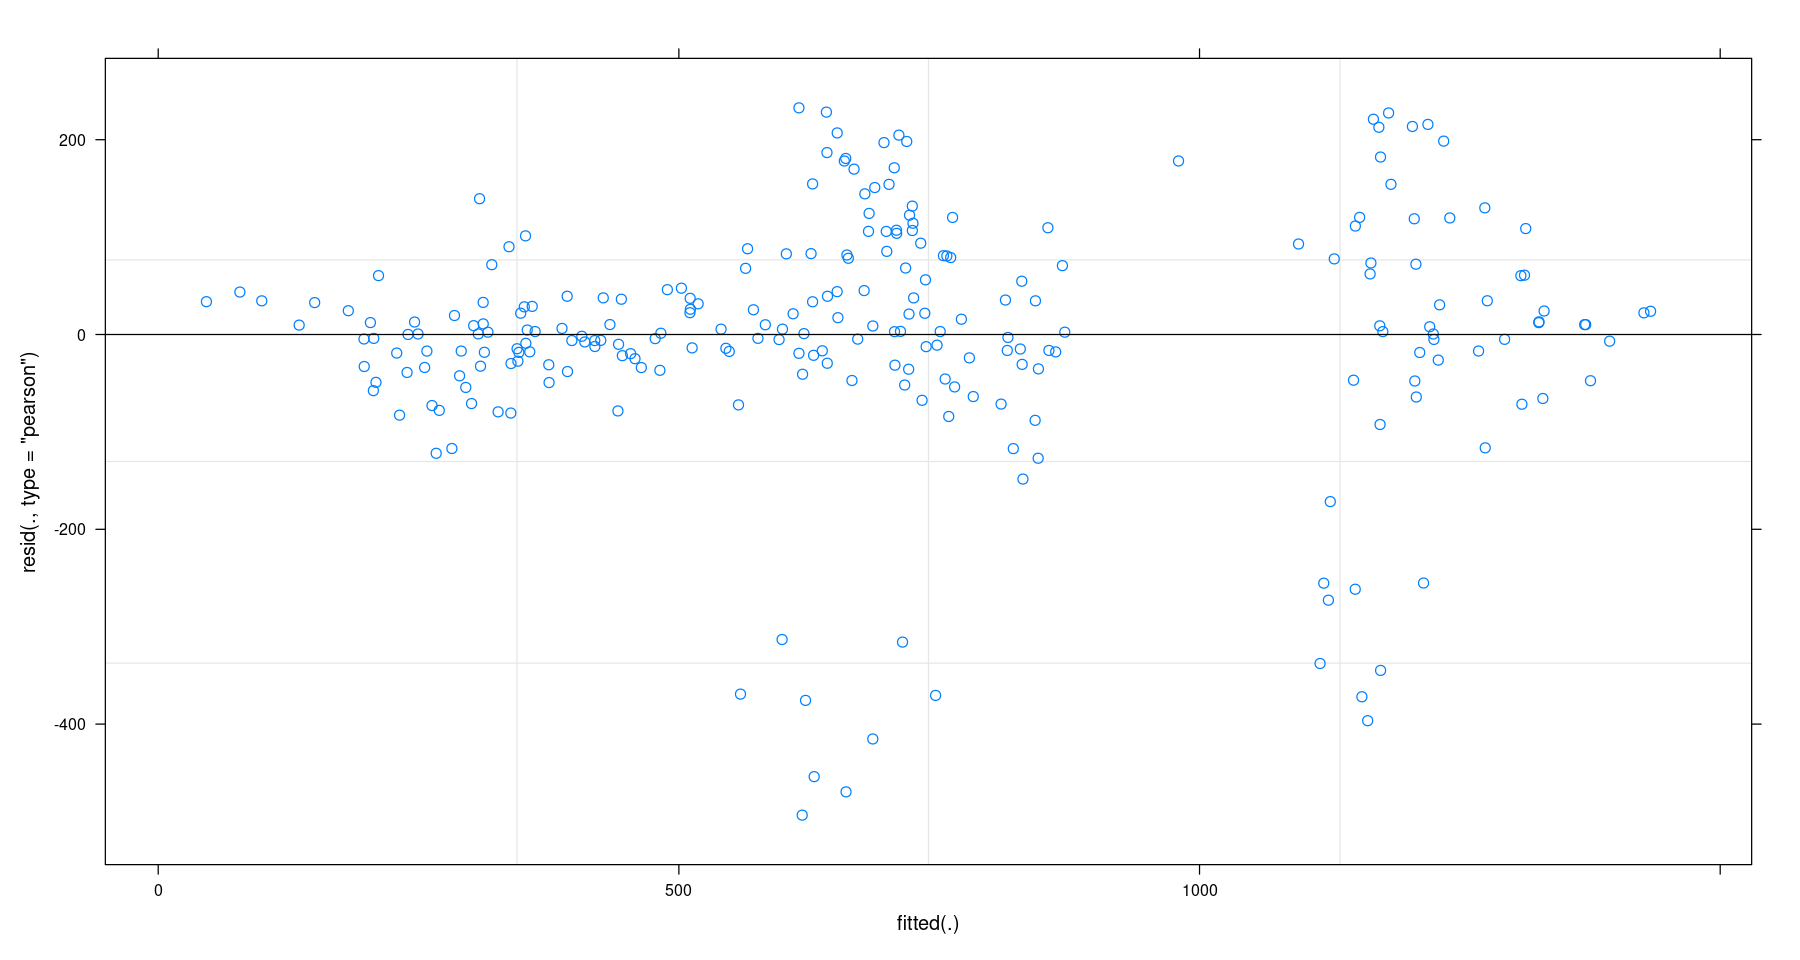

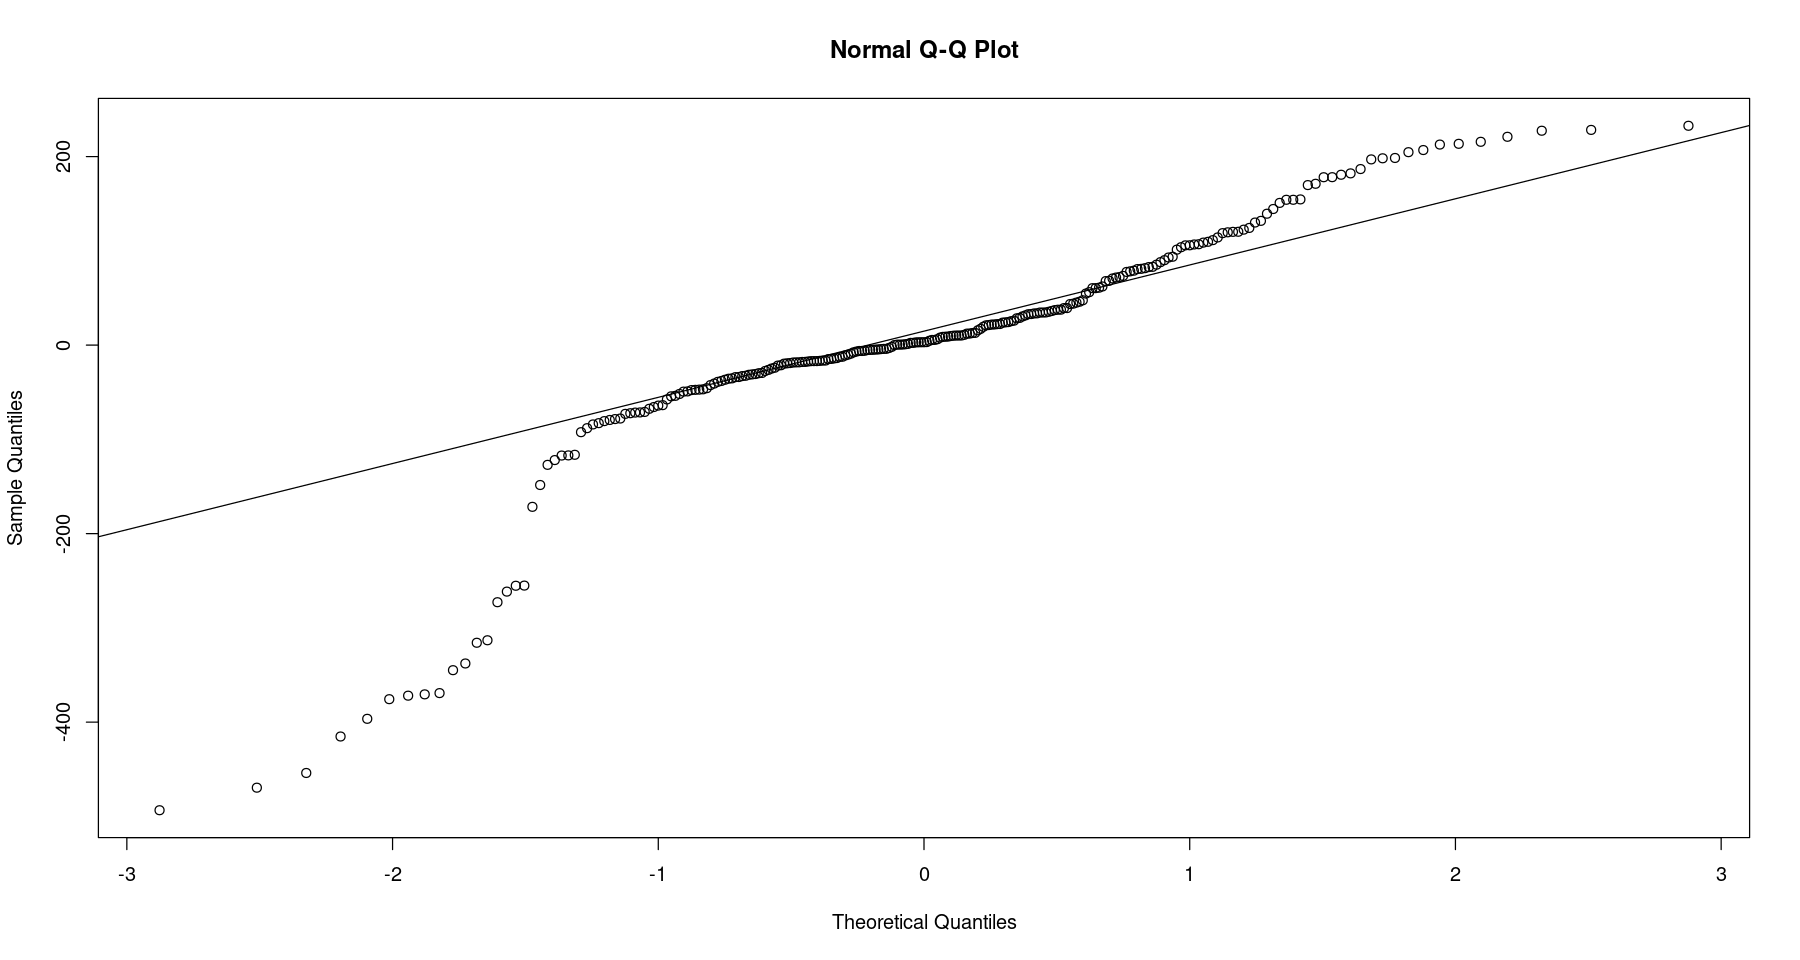

In [60]:
plot(model)
qqnorm(resid(model))
qqline(resid(model))


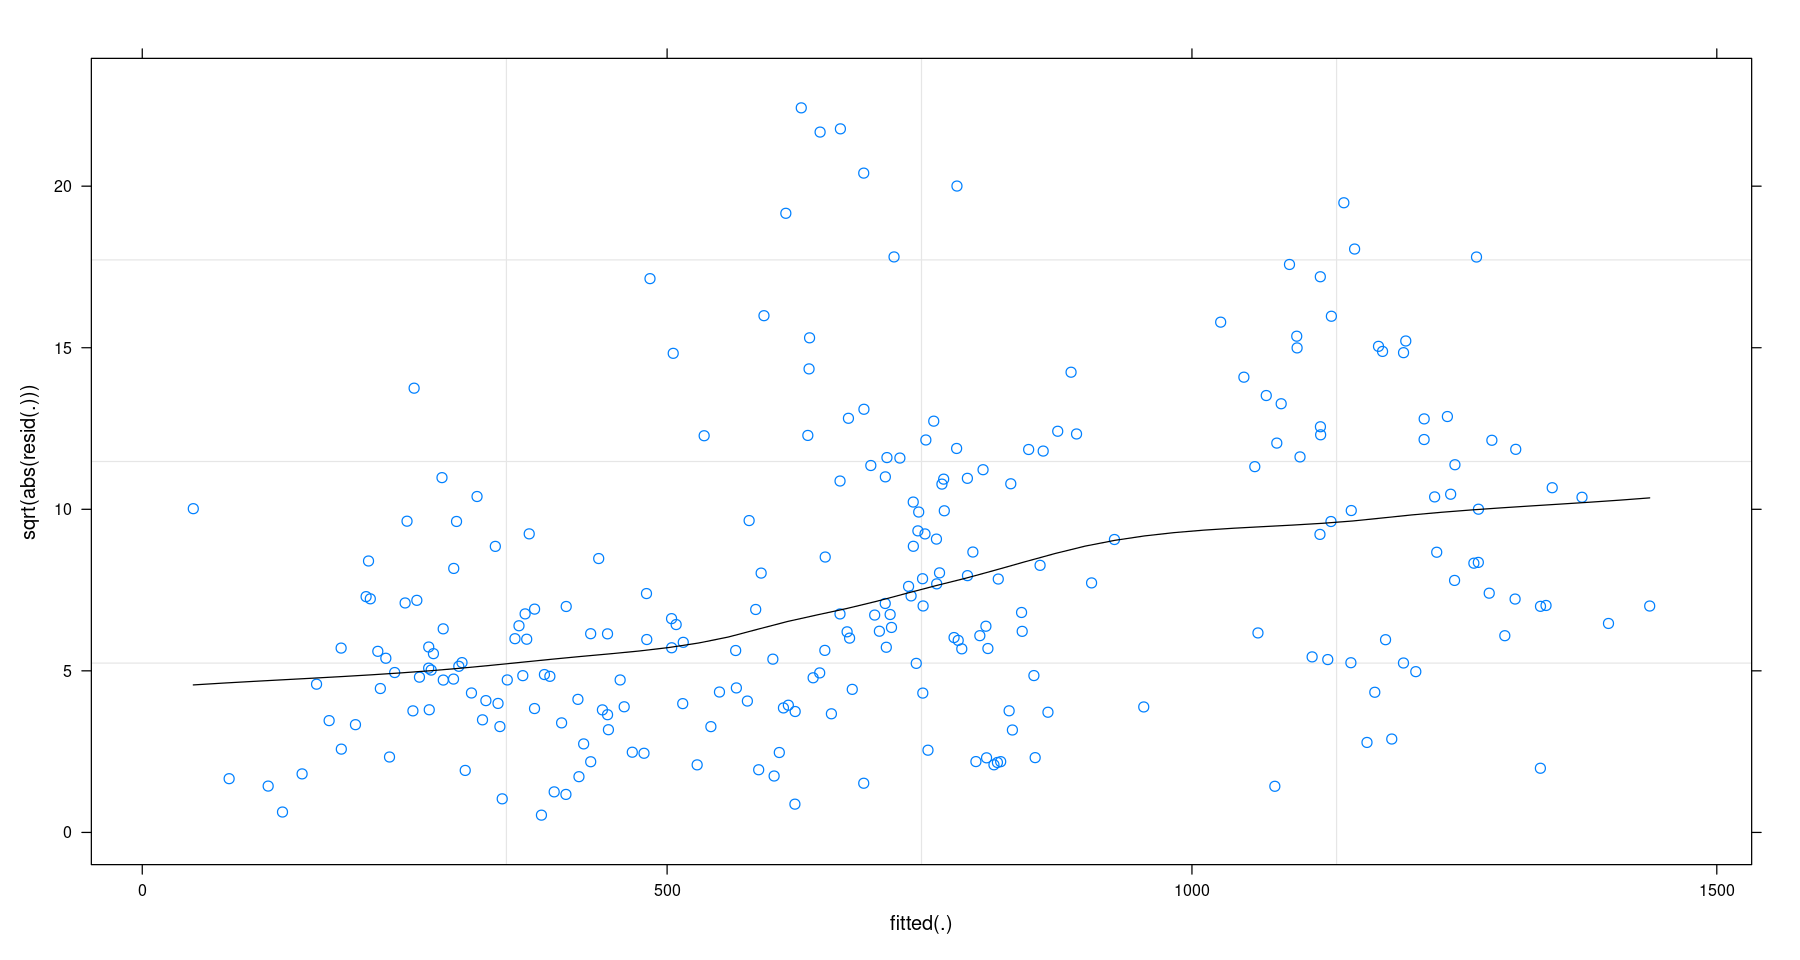

In [56]:
plot(model,
     sqrt(abs(resid(.)))~fitted(.),
     type=c("p","smooth"), col.line=1)

In [111]:
confint(model)

Computing profile confidence intervals ...

Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“unexpected decrease in profile: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“unexpected decrease in profile: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“unexpected decrease in profile: using 

Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in zetafun(np, ns):
“slightly lower deviances (diff=-1.81899e-12) detected”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“unexpected decrease in profile: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in nextpar(mat, cc, i, delta, lowcut, upcut):
“Last two rows have identical or NA .zeta values: using minstep”
Warning message in nextpar(mat, cc, 

,2.5 %,97.5 %
.sig01,382.0850,495.54725
.sig02,0.0000,523.84604
.sig03,477.7205,638.92986
.sigma,164.0259,189.05658
(Intercept),170.1520,771.63302
benchmarksqlite3_ossfuzz,2780.7794,3585.47191
benchmarkzlib_zlib_uncompress_fuzzer,-732.3681,100.67308
corpuse1v0-libfuzzer,-374.8244,453.70918
fuzzeraflplusplus,359.5983,554.76988
fuzzerentropic,487.8381,683.06067


In [100]:
ranef(model)$initial_coverage

,(Intercept)
,<dbl>
96,133.702738
144,196.773030
183,58.943174
192,149.312304
194,159.711465
196,47.167204
213,132.183621
231,71.496643
252,96.498864


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




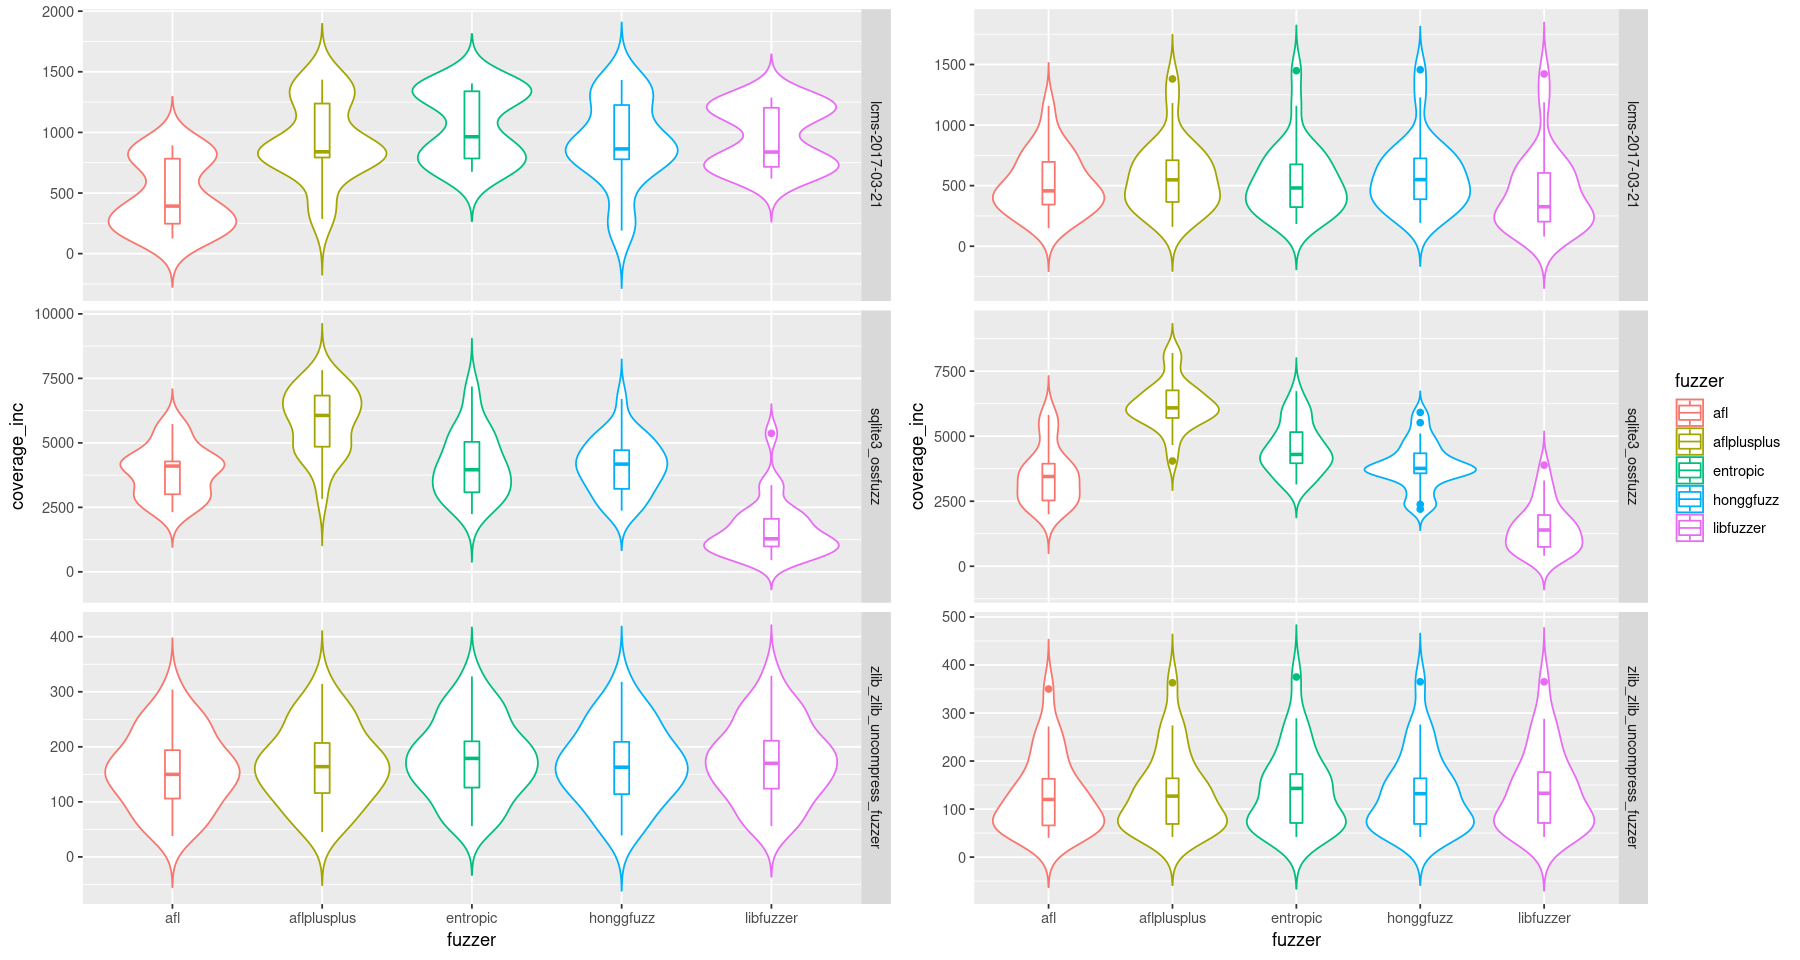

In [4]:
library("ggplot2")
require(gridExtra)

options(repr.plot.width=15, repr.plot.height=8)

p1 <- ggplot(d %>% filter(corpus == "e1v0-afl"), aes(x=fuzzer, y=coverage_inc, color=fuzzer)) + 
  geom_violin(trim=FALSE) + facet_grid(benchmark ~ ., scales = "free_y") + geom_boxplot(width=0.1) +
  theme(legend.position="none")

p2 <- ggplot(d %>% filter(corpus == "e1v0-libfuzzer"), aes(x=fuzzer, y=coverage_inc, color=fuzzer)) + 
  geom_violin(trim=FALSE) + facet_grid(benchmark ~ ., scales = "free_y") + geom_boxplot(width=0.1)

grid.arrange(p1, p2, ncol=2)

In [24]:
# @TODO do this for current data
require(dplyr)

library(MASS)
library(effsize)

b <- "sqlite3_ossfuzz"
fA <- "honggfuzz"
fB <- "entropic"

bd <- d %>% filter(benchmark == b)
A <- bd %>% filter(fuzzer == fA)
B <- bd %>% filter(fuzzer == fB)
M <- merge(A, B, by = c("corpus", "benchmark", "per_target_trial"))
M["cov_diff"] <- M["coverage_inc.y"] - M["coverage_inc.x"]
M$cdif <- factor(M$cov_diff, ordered=TRUE)

Ma <- M %>% filter(corpus == "e1v0-afl")
Mb <- M %>% filter(corpus == "e1v0-libfuzzer")

P <- bd %>% filter(fuzzer == fA | fuzzer == fB)
Pa <- P %>% filter(corpus == "e1v0-afl")
Pb <- P %>% filter(corpus == "e1v0-libfuzzer")

# Wilcoxon and VD of two experiments -- both significant at p=0.05!
mean(Ma$cov_diff)
wilcox.test(Ma$coverage_inc.y, Ma$coverage_inc.x, paired=TRUE)
VD.A(Pa$coverage_inc, Pa$fuzzer)

cat("~~~~~~~~~~~")

mean(Mb$cov_diff)
wilcox.test(Mb$coverage_inc.y, Mb$coverage_inc.x, paired=TRUE) 
VD.A(Pb$coverage_inc, Pb$fuzzer)

cat("~~~~~~~~~~~")

Pex <- P %>% filter(fuzzer == fA)
VD.A(Pex$coverage_inc, Pex$experiment)

Pex <- P %>% filter(fuzzer == fB)
VD.A(Pex$coverage_inc, Pex$experiment)

[1] 44.52

Warning message in wilcox.test.default(Ma$coverage_inc.y, Ma$coverage_inc.x, paired = TRUE):
“cannot compute exact p-value with ties”



	Wilcoxon signed rank test with continuity correction

data:  Ma$coverage_inc.y and Ma$coverage_inc.x
V = 164, p-value = 0.9785
alternative hypothesis: true location shift is not equal to 0



Vargha and Delaney A

A estimate: 0.4888 (negligible)


~~~~~~~~~~~

[1] 689.84


	Wilcoxon signed rank exact test

data:  Mb$coverage_inc.y and Mb$coverage_inc.x
V = 314, p-value = 3.278e-06
alternative hypothesis: true location shift is not equal to 0



Vargha and Delaney A

A estimate: 0.7008 (medium)


~~~~~~~~~~~


Vargha and Delaney A

A estimate: NaN (NA)



Vargha and Delaney A

A estimate: NaN (NA)
